## Imports

In [1]:
import dgl
import numpy as np
import pandas as pd
import time
import networkx as nx
import itertools

from helper_functions import build_map_1

Using backend: pytorch


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv

## Creating the graph:

In [3]:
# CONSTANTS

n_states = 34

In [187]:
G = dgl.DGLGraph()
G.add_nodes(n_states)
u, v = build_map_1()
G = dgl.graph((u, v))

G.add_edges(G.nodes(), G.nodes())

In [188]:
print(G.number_of_nodes())
print(G.number_of_edges())
print(G)

34
162
Graph(num_nodes=34, num_edges=162,
      ndata_schemes={}
      edata_schemes={})


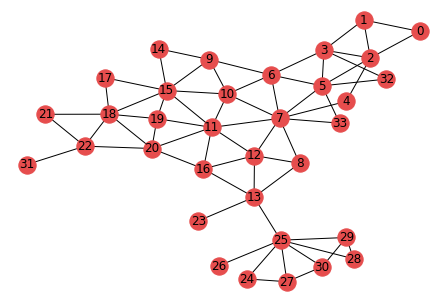

In [189]:
nx_G = G.to_networkx().to_undirected()
pos = nx.kamada_kawai_layout(nx_G)

nx.draw(nx_G, pos, with_labels=True, node_color=[[.9, .3, .3]])

## Loading the data:

In [7]:
with open('./data/states_list.txt', 'r') as file:
    states = file.readlines()

for ind in range(len(states) - 1):
    states[ind] = states[ind][:-1]

In [8]:
states[:3]

['Ladakh', 'Jammu and Kashmir', 'Himachal Pradesh']

In [9]:
df = pd.read_csv("./data/state_data.csv")
df.head(5)

,Rank,State or union territory,Population,National Share (%),Decadal growth(2001–2012),Rural population,Percent rural,Urban population,Percent urban,Area[16],Density[a],Sex ratio,Foreign Visits,Health Index
0,1,Uttar Pradesh,"199,812,341",16.51,20.2%,"155,317,278",77.73,"44,495,063",22.27,"240,928 km2 (93,023 sq mi)",828.0,912,4745181,29.16
1,2,Maharashtra,"112,374,333",9.28,20.0%,"61,556,074",54.78,"50,818,259",45.22,"307,713 km2 (118,809 sq mi)",365.0,929,5528704,64.53
2,3,Bihar,"104,099,452",8.60,25.4%,"92,341,436",88.71,"11,758,016",11.29,"94,163 km2 (36,357 sq mi)",1102.0,918,1093141,32.42
3,4,West Bengal,"91,276,115",7.54,13.8%,"62,183,113",68.13,"29,093,002",31.87,"88,752 km2 (34,267 sq mi)",1029.0,953,1656145,58.25
4,5,Madhya Pradesh,"72,626,809",6.00,16.3%,"52,557,404",72.37,"20,069,405",27.63,"308,245 km2 (119,014 sq mi)",236.0,931,327958,38.69


In [10]:
actual_data = pd.read_csv("./data/actual_covid_data_17april.csv")
actual_data = actual_data.drop([0, 37]).reset_index(drop=True)
actual_data = actual_data.drop([32, 35]).reset_index(drop=True)
actual_data.iloc[5, 0] = 'NCT of Delhi'

In [11]:
case_data = actual_data[['State', 'Confirmed']]
case_data['label'] = 0

label_1 = case_data['Confirmed'].quantile(q=1/3)
label_2 = case_data['Confirmed'].quantile(q=2/3)

case_data.iloc[case_data.index[case_data['Confirmed'] >= label_1], 2] = 1
case_data.iloc[case_data.index[case_data['Confirmed'] >= label_2], 2] = 2

c:\users\siddh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\siddh\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [12]:
#case_data.iloc[case_data.index[case_data['Confirmed'] >= 121403], 2] = 1
#case_data.iloc[case_data.index[case_data['Confirmed'] >= 384563], 2] = 2

In [13]:
y_true = []
for state in states:
    y_true.append(case_data[case_data['State'] == state]['label'].values[0])

In [48]:
roads_dict = {}

In [68]:
roads_dict['Ladakh'] = '1'

In [ ]:
for state in states[1:]:
    print(state)
    inp = input()
    roads_dict[state] = inp
#roads_dict

In [141]:
try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

with open('./data/road_data.p', 'wb') as fp:
    pickle.dump(roads_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [70]:
set_dict = {}
for state in roads_dict:
    roads = roads_dict[state].split(',')
    roads = list(map(lambda x: x.strip(), roads))
    set_dict[state] = set(roads)

In [79]:
adj = np.zeros((n_states, n_states))

In [80]:
for i in range(len(states)):
    for j in range(len(states)):
        state_1 = states[i]
        state_2 = states[j]
        adj[i][j] = len(set_dict[state_1].intersection(set_dict[state_2]))
        #print("\t", state_2, len(un))


In [142]:
adj

array([[ 1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1., 12.,  1., ...,  0.,  0.,  1.],
       [ 0.,  1., 19., ...,  0.,  1.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  2.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  1.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0., 11.]])

In [174]:
G = dgl.DGLGraph()
G.add_nodes(n_states)
#u, v = build_map_1()
#G = dgl.graph((u, v))

In [175]:
for i in range(len(states)):
    fr = []
    to = []
    feat = []
    for j in range(len(states)):
        if adj[i][j] != 0:
            fr.append(i)
            to.append(j)
            feat.append(adj[i][j])
    G.add_edges(torch.tensor(fr), torch.tensor(to))# data={'h': torch.tensor(feat)})

## Encoding the features:

In [14]:
#G.ndata['feat']

In [133]:
from scipy.stats import pearsonr

arr = []
for i in range(n_states):
    arr.append(df[df['State or union territory'] == states[i]]['National Share (%)'].values[0])
print(pearsonr(y_true, arr))

our_data = features[[32, 27, 3, 15, 20, 16], :]

#mean = our_data.mean(axis=0)
#std = our_data.std(axis=0)

#our_data = (our_data - mean) / std

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(our_data, [0, 0, 1, 2, 2, 1])

(clf.predict(features)[test_mask] == np.array(y_true)[test_mask]).mean()

(0.6764452227916168, 1.124784186686754e-05)


0.32142857142857145

In [176]:
G

Graph(num_nodes=34, num_edges=290,
      ndata_schemes={}
      edata_schemes={})

## Creating and training the model:

In [177]:
def evaluate(model, g, features, labels, mask):
    model.eval()
    with th.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = th.max(logits, dim=1)
        correct = th.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

In [190]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph

gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, feature):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            g.ndata['h'] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata['h']
            return self.linear(h)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = GCNLayer(34, 2)
        self.layer2 = GCNLayer(2, 3)

    def forward(self, g, features):
        x = F.leaky_relu(self.layer1(g, features))
        x = self.layer2(g, x)
        return x

In [191]:
# Add edges between each node and itself to preserve old node representations
net = Net()

optimizer = th.optim.Adam(net.parameters(), lr=0.01)
dur = []
for epoch in range(200):
    if epoch >= 3 :
        t0 = time.time()

    net.train()
    logits = net(G, features)
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >= 3:
        dur.append(time.time() - t0)

    acc = evaluate(net, G, features, labels, test_mask)
    if epoch % 20 == 0:
        #print(logp)
        print("Epoch {:05d} | Loss {:.4f} | Test Acc {:.4f} | Time(s) {:.4f}".format(
                epoch, loss.item(), acc, np.mean(dur)))

Epoch 00000 | Loss 181.6991 | Test Acc 0.2143 | Time(s) nan
Epoch 00020 | Loss 3.8379 | Test Acc 0.5000 | Time(s) 0.0079
Epoch 00040 | Loss 1.0977 | Test Acc 0.6071 | Time(s) 0.0083
Epoch 00060 | Loss 0.8040 | Test Acc 0.3571 | Time(s) 0.0082
Epoch 00080 | Loss 0.6933 | Test Acc 0.5714 | Time(s) 0.0083
Epoch 00100 | Loss 0.5829 | Test Acc 0.5714 | Time(s) 0.0083
Epoch 00120 | Loss 0.4517 | Test Acc 0.6429 | Time(s) 0.0084
Epoch 00140 | Loss 0.4346 | Test Acc 0.6071 | Time(s) 0.0083
Epoch 00160 | Loss 0.3382 | Test Acc 0.7143 | Time(s) 0.0082
Epoch 00180 | Loss 0.2658 | Test Acc 0.6786 | Time(s) 0.0083


In [156]:
G
#G.add_edges(G.nodes(), G.nodes())

Graph(num_nodes=34, num_edges=162,
      ndata_schemes={}
      edata_schemes={})

In [183]:
n_feats = 2

features = torch.zeros((n_states, n_states))
feats = []
for i in range(n_states):
    
    density = df[df['State or union territory'] == states[i]]['Density[a]'].values[0]
    percent_urban = df[df['State or union territory'] == states[i]]['Percent urban'].values[0]
    health_index = df[df['State or union territory'] == states[i]]['Health Index'].values[0]
    foreign_visits = df[df['State or union territory'] == states[i]]['Foreign Visits'].values[0]
    percent_rural = df[df['State or union territory'] == states[i]]['Percent rural'].values[0]
    share = df[df['State or union territory'] == states[i]]['National Share (%)'].values[0]
    
    # adding the features we want: 
    features[i][i] = density
    #features[i][1] = share

In [184]:
#features[i][i] = (features[i][i] - feats.mean()) / feats.std()

In [185]:
features

tensor([[2.8000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 2.9700e+02, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.2300e+02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.5980e+03, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 9.2520e+03,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.1297e+04]])

In [166]:
labels

tensor([0, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 0, 2, 1, 1, 2, 1, 2, 2, 2, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 2])

In [167]:
labels = torch.tensor(y_true)

In [168]:
train_mask = torch.zeros(n_states)
train_mask[[32, 27, 3, 15, 20, 16]] = 1
train_mask = train_mask.bool()
train_mask

tensor([False, False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False,  True,  True, False, False, False,
         True, False, False, False, False, False, False,  True, False, False,
        False, False,  True, False])

In [169]:
test_mask = torch.zeros(n_states)
test_mask = ~train_mask
test_mask = test_mask.bool()
test_mask

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False, False,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True, False,  True])

In [23]:
features.shape, labels.shape, train_mask.shape

(torch.Size([34, 34]), torch.Size([34]), torch.Size([34]))

## Results:

In [21]:
op_df = pd.DataFrame(all_logits[-1][:].numpy())
op_list = []

for i in range(n_states):
    op_list.append((all_logits[-1][i].numpy().argmax()))

op_df['preds'] = pd.Series(op_list)
op_df['State'] = states

In [22]:
final_df = pd.merge(op_df, case_data, on='State').sort_values('label', ascending=False)[['State', 'preds', 'label']]
(final_df['preds'] == final_df['label']).mean()

0.5

In [23]:
final_df

,State,preds,label
33,NCT of Delhi,0,2
22,Tamil Nadu,2,2
21,Kerala,2,2
20,Andhra Pradesh,2,2
6,Rajasthan,0,2
7,Uttar Pradesh,0,2
9,Gujarat,0,2
10,Madhya Pradesh,0,2
11,Chhattisgarh,2,2
18,Karnataka,2,2
